<a href="https://colab.research.google.com/github/WeizmannMLcourse/homework1-ariels1234/blob/main/homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quantum Parameters Estimation with Neural Networks


In [1]:
# Enabling access to the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Creating a path to my drive for importing the relevant modules
import sys
import os
root_path = "/content/drive/MyDrive/GitHub/Project_CNN/"
sys.path.append(os.path.abspath(root_path))


In [ ]:
# Unzipping the Dateset file from the google drive
!unzip '/content/drive/MyDrive/GitHub/Project/Dataset.zip'


In [5]:
import matplotlib as plt

In [6]:
# Defining the path to the relevant data
path_to_training_data = '/content/Dataset/training'
path_to_validation_data = '/content/Dataset/validation'

In [7]:
# Generating a list of the files in the directory using glob

import glob

filelist = glob.glob(path_to_training_data+'/*.npy')

#print the first 10 entries:
filelist[1:10]

['/content/Dataset/training/repetition=81 omega=1  gamma=7 delta=1 serial=6.npy',
 '/content/Dataset/training/repetition=79 omega=2  gamma=1 delta=1 serial=10.npy',
 '/content/Dataset/training/repetition=63 omega=5  gamma=10 delta=1 serial=49.npy',
 '/content/Dataset/training/repetition=18 omega=5  gamma=7 delta=1 serial=46.npy',
 '/content/Dataset/training/repetition=52 omega=9  gamma=4 delta=1 serial=83.npy',
 '/content/Dataset/training/repetition=60 omega=10  gamma=4 delta=1 serial=93.npy',
 '/content/Dataset/training/repetition=34 omega=4  gamma=8 delta=1 serial=37.npy',
 '/content/Dataset/training/repetition=36 omega=3  gamma=8 delta=1 serial=27.npy',
 '/content/Dataset/training/repetition=85 omega=4  gamma=10 delta=1 serial=39.npy']

In [8]:
# activating the autoloader
%load_ext autoreload
%autoreload 2

## Importing the dataloader



In [9]:
from dataloader import CustomDataset


In [10]:
training_ds = CustomDataset(path_to_training_data, transform=True)
validation_ds = CustomDataset(path_to_validation_data)

some_random_idx = 30
training_ds[some_random_idx]

(tensor([[0.0000e+00, 4.9000e-05, 1.9424e-04,  ..., 4.5402e-01, 4.5465e-01,
          4.5527e-01],
         [0.0000e+00, 4.9000e-05, 1.9424e-04,  ..., 4.5402e-01, 4.5465e-01,
          4.5527e-01],
         [0.0000e+00, 4.9000e-05, 1.9424e-04,  ..., 4.5402e-01, 4.5465e-01,
          4.5527e-01]], dtype=torch.float64),
 tensor(68))

## Creating the dataloader

In [11]:
from torch.utils.data import Dataset, DataLoader

training_dataloader = DataLoader(training_ds,batch_size=300,shuffle=True)
valid_dataloader = DataLoader(validation_ds,batch_size=300)

In [12]:
# check
for x,y in training_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([300, 3, 5000]) torch.Size([300])


# Importing the nerual network

In [13]:
from model import CNN_Net


In [62]:
net = CNN_Net()

In [15]:
# checking the size of our model
z=net(x.float())
print(z)

tensor([[ 0.0045,  0.0141, -0.0102,  ..., -0.0055,  0.0022,  0.0024],
        [ 0.0047,  0.0142, -0.0103,  ..., -0.0054,  0.0022,  0.0022],
        [ 0.0047,  0.0141, -0.0102,  ..., -0.0055,  0.0022,  0.0022],
        ...,
        [ 0.0046,  0.0142, -0.0103,  ..., -0.0055,  0.0022,  0.0022],
        [ 0.0047,  0.0141, -0.0102,  ..., -0.0056,  0.0022,  0.0022],
        [ 0.0045,  0.0141, -0.0102,  ..., -0.0056,  0.0021,  0.0022]],
       grad_fn=<AddmmBackward0>)


## Training


In [63]:
import torch
import torch.nn as nn
import torch.optim as optim


loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [64]:
def compute_accuracy_and_loss(dataloader,net):
    total = 0
    correct = 0
    loss = 0

    if torch.cuda.is_available():
        net.cuda()
    net.eval()

    n_batches = 0
    with torch.no_grad():
        for x,y in dataloader:
            n_batches+=1

            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()

            pred = net(x.float())

            loss+= loss_func(pred, y).item()

            pred = torch.argmax(pred,dim=1)

            correct+=len(torch.where((pred==y))[0])
            total+=len(y)

    loss = loss/n_batches

    return correct/total, loss

In [17]:
#net.load_state_dict(torch.load('/content/drive/MyDrive/GitHub/Project_CNN/trained_model.pt',map_location='cpu'))

In [18]:
#net.eval()
#net.cpu()
# predicted = net( x.unsqueeze(1) )[0][0].data.numpy()

In [65]:
compute_accuracy_and_loss(training_dataloader,net)

(0.01, 4.605188538046444)

In [66]:
compute_accuracy_and_loss(valid_dataloader,net)

(0.01, 4.605172858518713)

In [67]:
if torch.cuda.is_available():
    net.cuda()

In [68]:
from tqdm.notebook import tqdm
import time

n_epochs = 100

t0=time.time()
training_loss_vs_epoch = []
validation_loss_vs_epoch = []

training_acc_vs_epoch = []
validation_acc_vs_epoch = []

pbar = tqdm(range(n_epochs))

for epoch in pbar:
    t1=round((time.time()-t0)/60)
    if len(training_loss_vs_epoch) > 1:
        pbar.set_description('val acc:'+'{0:.5f}'.format(validation_acc_vs_epoch[-1])+
        ', train acc:'+'{0:.5f}'.format(training_acc_vs_epoch[-1]))
        print(epoch, 'train loss',training_loss_vs_epoch[-1],'acc', (training_acc_vs_epoch[-1]),' Time: ', round(t1))

    net.train() # put the net into "training mode"

    for x,y in training_dataloader:
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        optimizer.zero_grad()
        output = net(x.float())
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()


    net.eval() #put the net into evaluation mode


    train_acc, train_loss = compute_accuracy_and_loss(training_dataloader,net)
    valid_acc, valid_loss =  compute_accuracy_and_loss(valid_dataloader,net)

    training_loss_vs_epoch.append(train_loss)
    training_acc_vs_epoch.append(train_acc)

    validation_acc_vs_epoch.append(valid_acc)

    validation_loss_vs_epoch.append(valid_loss)

    #save the model if the validation loss has decreased
    # if len(validation_loss_vs_epoch)==1 or validsation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
    #     torch.save(net.state_dict(), '/content/gdrive/MyDrive/Deep_learning/Lesson 1/HW1/trained_model.pt')
    if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
        torch.save(net.state_dict(), '/content/drive/MyDrive/GitHub/Project_CNN/trained_model_2024_.pt')



  0%|          | 0/100 [00:00<?, ?it/s]

2 train loss 3.8323854488485 acc 0.0955  Time:  2
3 train loss 3.2485962475047394 acc 0.1708  Time:  2
4 train loss 2.5505318010554596 acc 0.302  Time:  3
5 train loss 1.7800164117532618 acc 0.4811  Time:  4
6 train loss 1.409141926204457 acc 0.58  Time:  5
7 train loss 0.8467826808200163 acc 0.743  Time:  6
8 train loss 0.42024439573287964 acc 0.8747  Time:  7
9 train loss 0.1700148599989274 acc 0.9457  Time:  7
10 train loss 0.2129437011830947 acc 0.9208  Time:  8
11 train loss 0.11964856285382719 acc 0.9594  Time:  9
12 train loss 0.11186410453827943 acc 0.9607  Time:  10
13 train loss 0.10422720782020513 acc 0.9706  Time:  11
14 train loss 0.06016564801992739 acc 0.9759  Time:  11
15 train loss 0.02282981897759087 acc 0.9958  Time:  12
16 train loss 0.045444650904220694 acc 0.9764  Time:  13
17 train loss 0.0765882769928259 acc 0.9704  Time:  14
18 train loss 0.03198917470324565 acc 0.994  Time:  15
19 train loss 0.08662445295382948 acc 0.9617  Time:  15
20 train loss 0.01813892005

KeyboardInterrupt: 

In [ ]:
# Loading a pretrained net
# net.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/Lesson 2/HW2-part2/trained_model1.pt',map_location='cpu'))

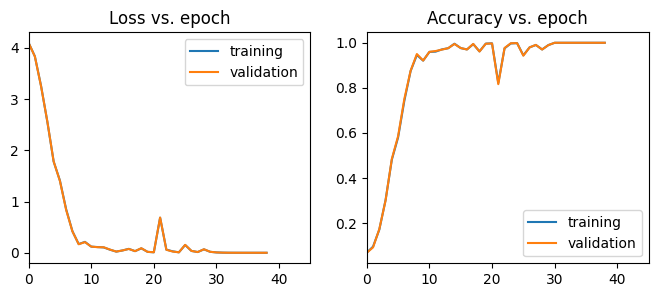

In [69]:
# plotting the result

import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(training_loss_vs_epoch,label='training')
ax[0].plot(validation_loss_vs_epoch,label='validation')
ax[0].set_xlim([0, 45])
ax[0].set_title('Loss vs. epoch')
ax[0].legend()

ax[1].plot(training_acc_vs_epoch,label='training')
ax[1].plot(validation_acc_vs_epoch,label='validation')
ax[1].set_xlim([0, 45])
ax[1].set_title('Accuracy vs. epoch')
ax[1].legend()

plt.show()